In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
import geopandas as gpd
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [2]:
# Modules
from modules.connector import MyBigQuery, MySQL

In [3]:
bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [4]:
query = """
SELECT 

LOC.outer_postcode,
CASE 
    WHEN VEH.fuelType = 'Electric' THEN 'zev'
    ELSE 'nonzev'
END as zevstat,
COUNT(*) as total

FROM `rugged-baton-283921.location.test_locations` LOC
LEFT JOIN `rugged-baton-283921.mots_uk.tests` TST
ON CAST(LOC.test_cert_number AS STRING) = TST.motTestNumber
LEFT JOIN `rugged-baton-283921.mots_uk.vehicles`VEH
ON TST.vehicleId = VEH.vehicleId

WHERE LOC.test_completed > '2021-12-31'
AND TST.completedDate > '2021-12-31'
AND TST.completedDate < '2023-01-1'
AND VEH.registration in (SELECT registrationNumber FROM VES_dataset.VRN_UK WHERE typeApproval = 'M1')

GROUP BY LOC.outer_postcode, zevstat
"""

In [5]:
df = bq.from_bq_to_dataframe(query)

E0517 12:29:35.279932000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.279981000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.279986000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.279995000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.279999000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.280002000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.280007000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Illegal keepalive throttling value 
E0517 12:29:35.280011000 8666347008 client_channel.cc:673]             chand=0x7fc0eac09d90: Ille

In [6]:
df = df.pivot(index='outer_postcode', columns='zevstat', values='total')

In [50]:
df['zevperc'] = df.apply(lambda row: 100*row.zev / (row.nonzev +row.zev), axis=1)
# df['zevperc'] = round(df.zevperc.fillna(0), ndigits=1)

In [51]:
print("Number of MOT tests: {t}\nNumber of EV MOT tests: {te}\nNational EV percentage: {tp}%".format(
    t=(df.zev.sum()+df.nonzev.sum()),
    te=df.zev.sum(),
    tp=round(100*df.zev.sum() / (df.zev.sum()+df.nonzev.sum()), ndigits=2)
))

Number of MOT tests: 34129727
Number of EV MOT tests: 332035
National EV percentage: 0.97%


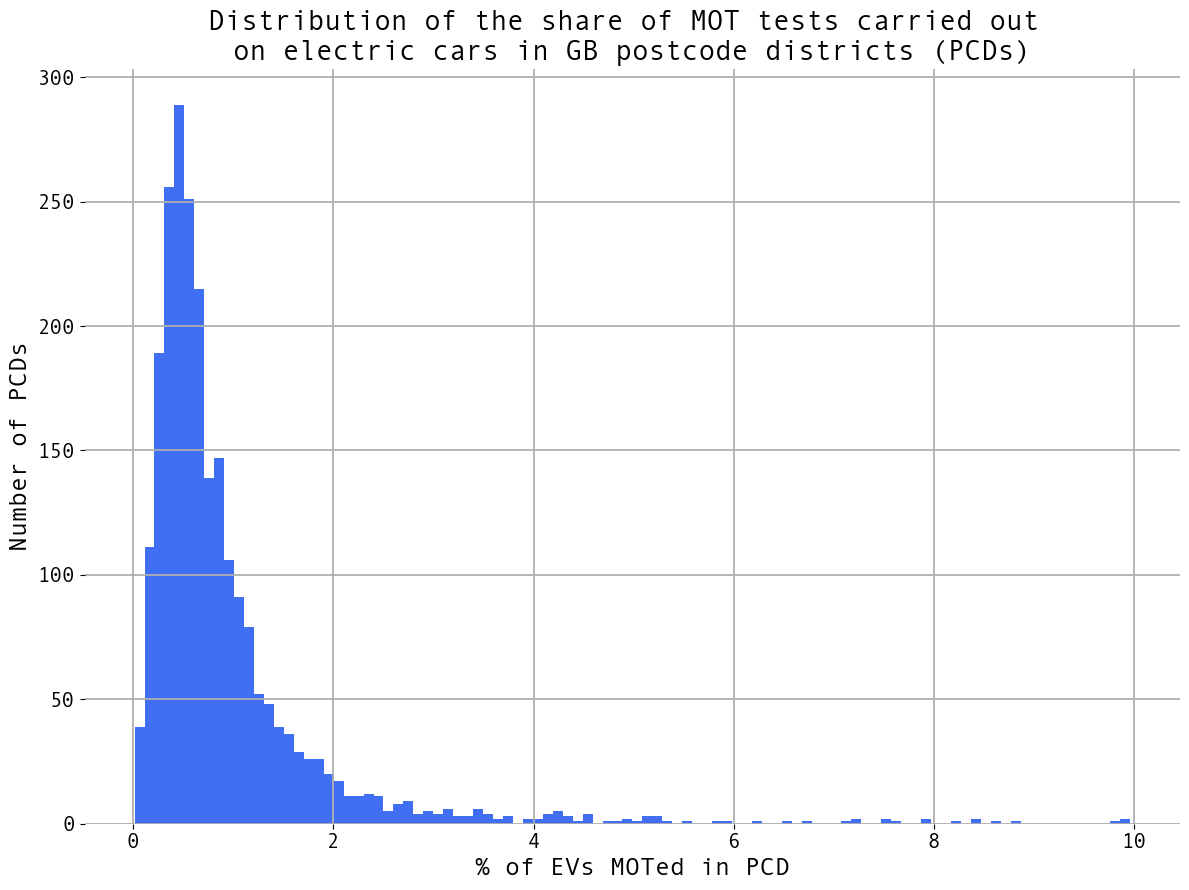

In [52]:
fig, ax = plt.subplots()

ax.hist(df[df.zevperc < 10].zevperc, bins=100)
ax.set_xlabel('% of EVs MOTed in PCD')
ax.set_ylabel('Number of PCDs')
ax.set_title('Distribution of the share of MOT tests carried out \non electric cars in GB postcode districts (PCDs)')

plt.savefig('plots/dist_mots_pcds.png', transparent=False, bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

In [53]:
gdf = gpd.read_file('data/GB_Postcodes/PostalDistrict.shp')

In [54]:
gdf = gdf.merge(df, how='left', right_index=True, left_on='PostDist')

In [55]:
gdf

,DistID,PostDist,PostArea,DistNum,PCCnt,AnomCnt,RefPC,x,y,Sprawl,Locale,geometry,nonzev,zev,zevperc
0,1,AB10,AB,10,725,2,AB106HA,392949,805109,Aberdeen,NaN,"POLYGON ((392500.960 805927.935, 392536.991 80...",7820,77,0.975054
1,2,AB11,AB,11,660,1,AB115QH,394404,805438,Aberdeen,NaN,"MULTIPOLYGON (((397283.458 805385.540, 397279....",12415,68,0.544741
2,3,AB12,AB,12,704,0,AB123LL,393407,800946,Aberdeen,NaN,"MULTIPOLYGON (((381763.351 798479.977, 382316....",55921,868,1.528465
3,4,AB13,AB,13,73,0,AB130EH,385705,801808,Milltimber,NaN,"POLYGON ((384002.001 803896.026, 384112.006 80...",<NA>,<NA>,NaN
4,5,AB14,AB,14,142,0,AB140LA,383616,801140,Peterculter,NaN,"POLYGON ((378503.427 802871.010, 378631.753 80...",1821,38,2.04411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,2732,YO7,YO,7,878,0,YO71SB,442456,481266,Thirsk,NaN,"POLYGON ((435311.453 485611.354, 435292.193 48...",12784,39,0.304141
2732,2733,YO8,YO,8,1209,0,YO88AG,461987,432038,Selby,NaN,"POLYGON ((455787.576 434833.140, 455761.645 43...",21521,96,0.444095
2733,2734,ZE1,ZE,1,319,0,ZE10RF,446175,1140943,Lerwick,NaN,"MULTIPOLYGON (((439144.961 1142076.953, 439999...",5009,54,1.066561
2734,2735,ZE2,ZE,2,303,1,ZE29PX,440489,1162938,Brae,NaN,"MULTIPOLYGON (((452501.127 1173299.466, 452500...",5171,43,0.824703


In [56]:
df.sort_values('zevperc', ascending=False).head(30)

zevstat,nonzev,zev,zevperc
outer_postcode,,,
W5,1711,2280,57.128539
SE4,9487,2605,21.543169
MK4,1843,315,14.596849
KW16,1679,247,12.824507
E16,17126,2226,11.502687
N1,653,82,11.156463
BS39,8767,1069,10.868239
N7,7014,776,9.961489
NW8,3766,414,9.904306


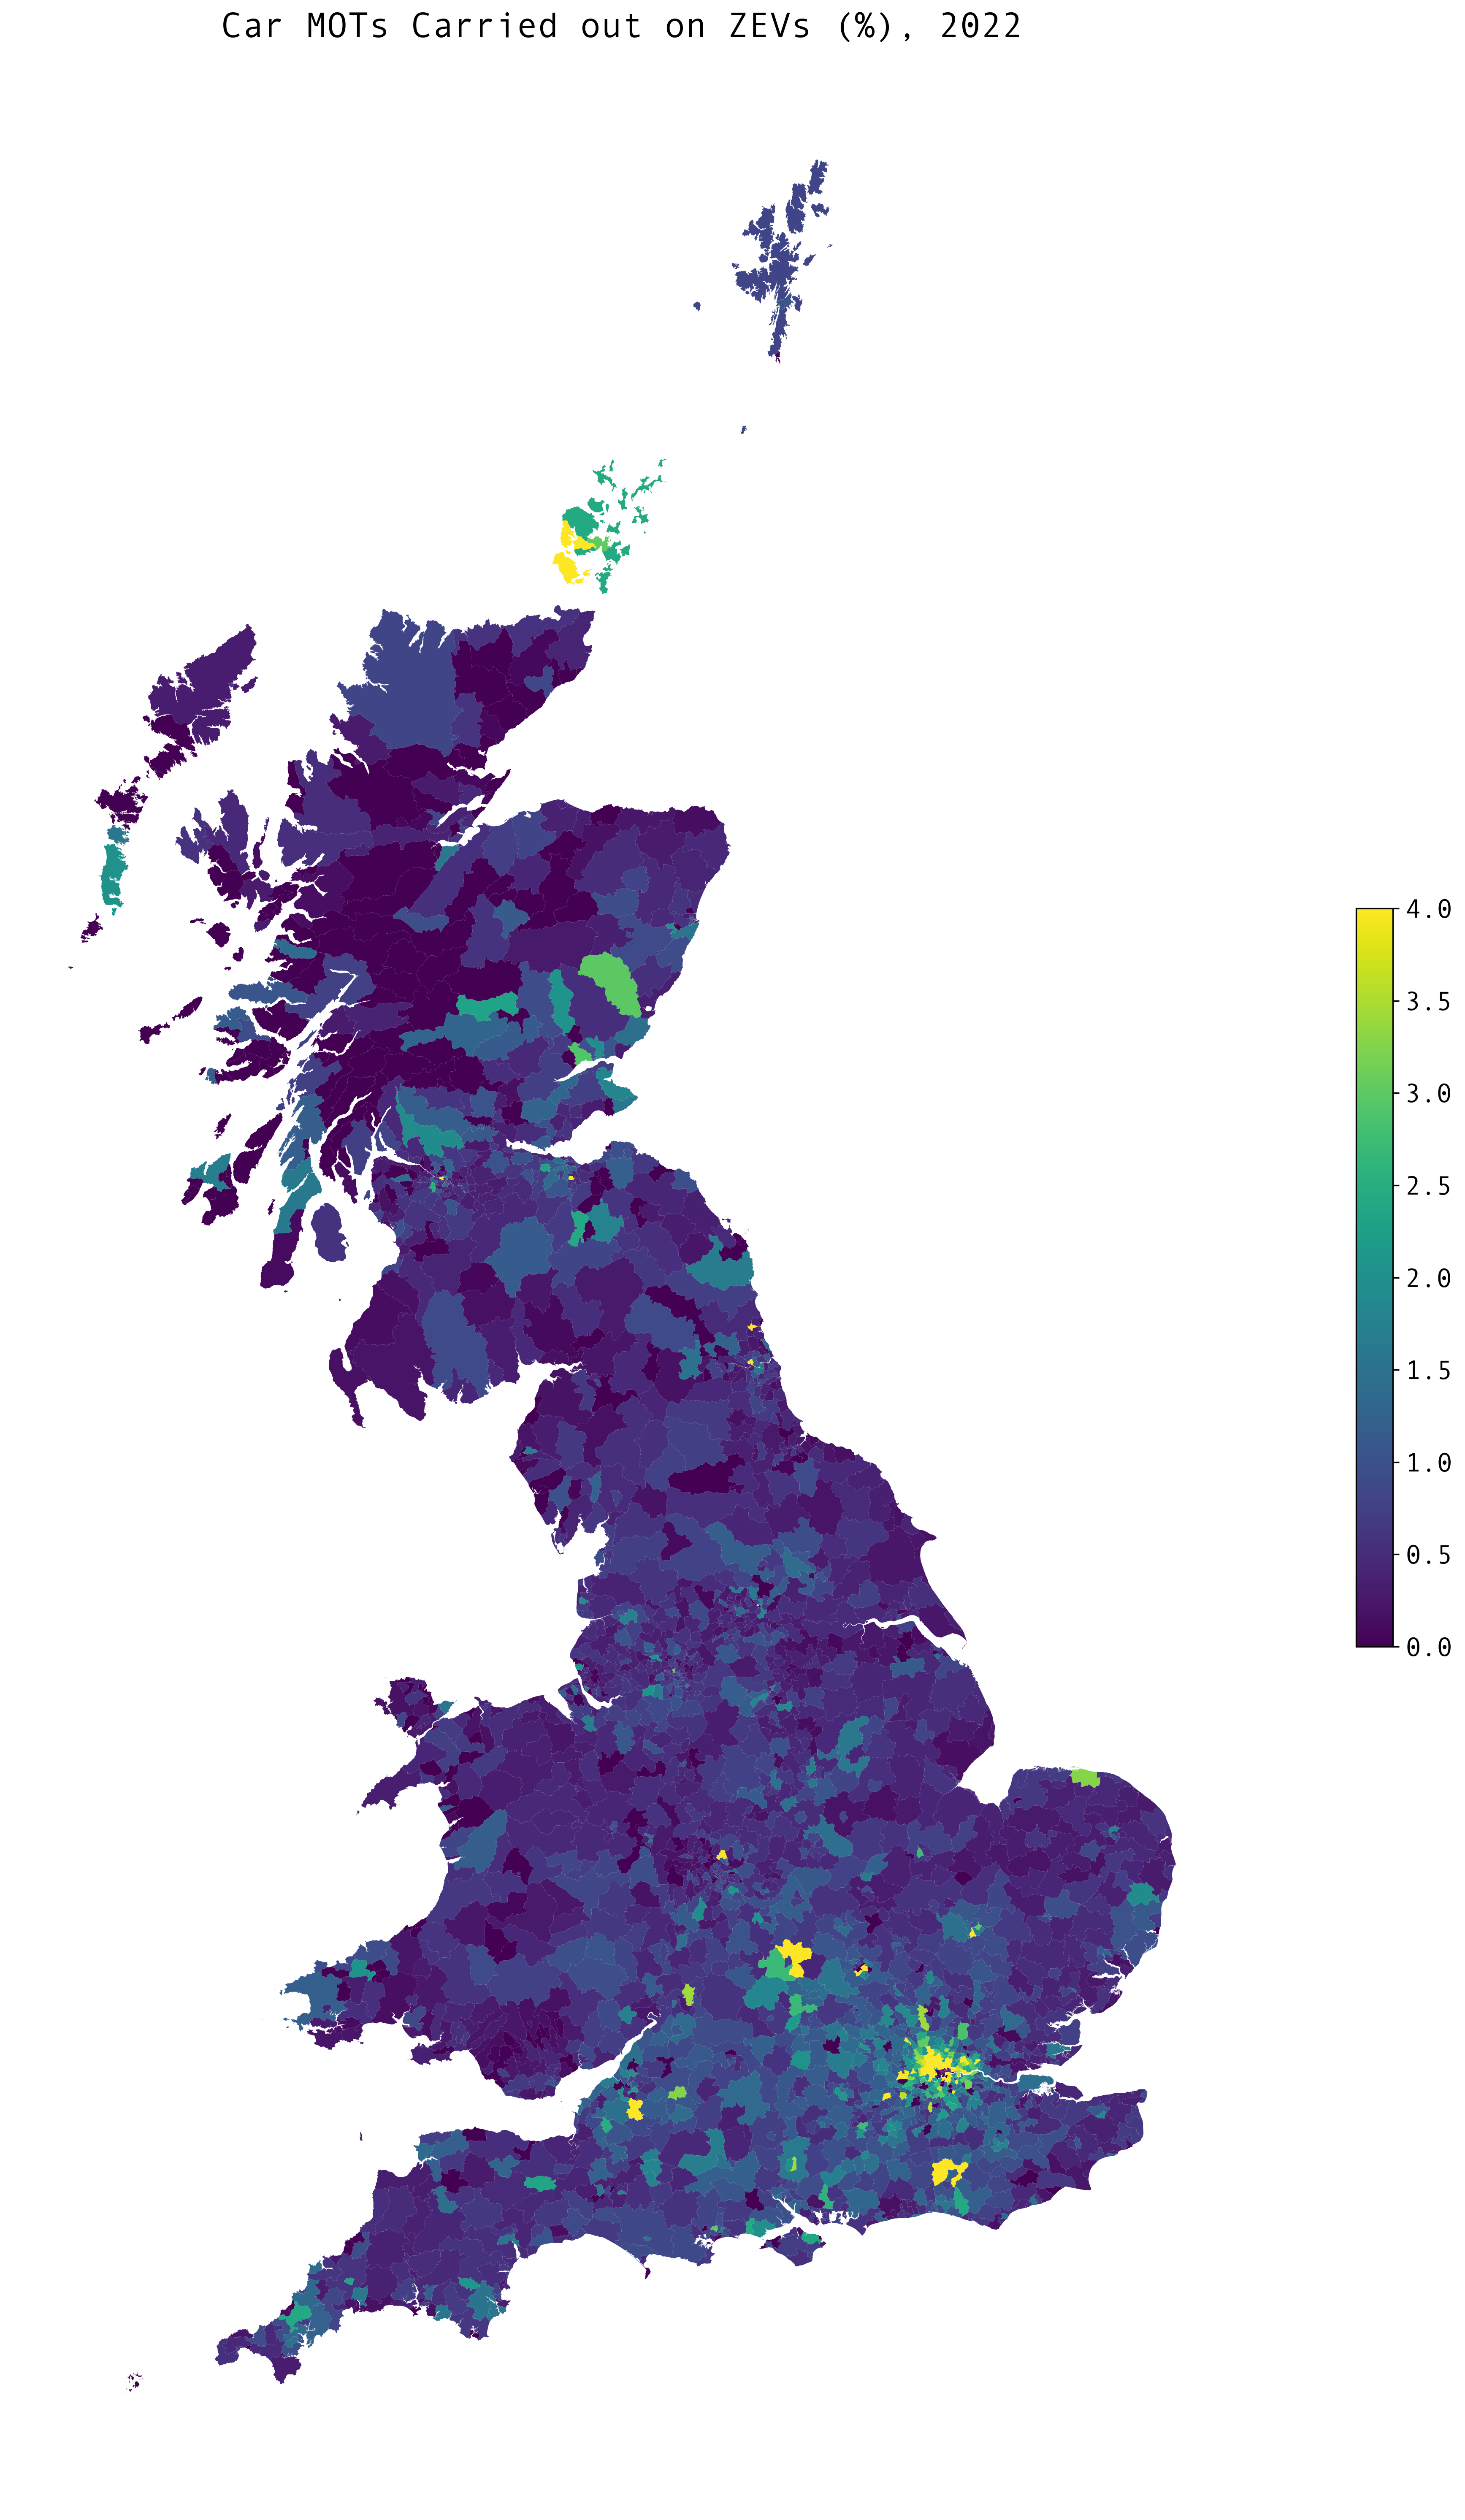

In [57]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)

gdf.fillna(0).plot(column='zevperc', vmax=4, legend=True, ax=ax, legend_kwds={'shrink': 0.3}) 
ax.set_title('Car MOTs Carried out on ZEVs (%), 2022')

ax.grid()
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('plots/mots_pcds.png', transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

## Regional Registration Data

In [ ]:
query = """
SELECT

"""